# STAT 206 Final Project

Description

In [139]:
import Pkg
Pkg.activate(pwd())
#Pkg.instantiate()
Pkg.status()

  Activating project at `~/STAT206_Final_Project`


   Resolving package versions...


  No Changes to `~/STAT206_Final_Project/Project.toml`
  No Changes to `~/STAT206_Final_Project/Manifest.toml`


Status `~/STAT206_Final_Project/Project.toml`
  [6e4b80f9] BenchmarkTools v1.4.0
  [336ed68f] CSV v0.10.12
  [324d7699] CategoricalArrays v0.10.8
  [5ae59095] Colors v0.12.10
  [a93c6f00] DataFrames v1.6.1
  [1313f7d8] DataFramesMeta v0.14.1
  [b4f34e82] Distances v0.10.11
  [31c24e10] Distributions v0.25.107
⌃ [587475ba] Flux v0.14.9
  [da1fdf0e] FreqTables v0.4.6
  [8d5ece8b] GLMNet v0.7.2
⌅ [28b8d3ca] GR v0.72.10
  [09f84164] HypothesisTests v0.11.0
  [7073ff75] IJulia v1.24.2
  [add582a8] MLJ v0.20.2
  [d354fa79] MLJClusteringInterface v0.1.11
  [094fc8d1] MLJFlux v0.4.0
⌃ [caf8df21] MLJGLMInterface v0.3.5
  [61c7150f] MLJLIBSVMInterface v0.2.1
  [6ee0df7b] MLJLinearModels v0.10.0
  [1b6a4a23] MLJMultivariateStatsInterface v0.5.3
  [33e4bacb] MLJNaiveBayesInterface v0.1.6
  [5ae90465] MLJScikitLearnInterface v0.6.1
  [636a865e] NearestNeighborModels v0.2.3
  [8b842266] PalmerPenguins v0.1.4
⌃ [91a5bcdd] Plots v1.39.0
  [8162dcfd] PrettyPrint v0.2.0
  [ce6b1742] RDatasets v0.7.7
⌃ [

In [140]:
using CSV, DataFrames
using Plots, StatsPlots
using Distributions
using Colors

In [141]:
nbadf = CSV.read("nba_2022_2023.csv", DataFrame, stringtype = String) |> dropmissing
#describe(nbadf)
rename!(nbadf,
Symbol("FG%")=>:FGpct,
Symbol("3P")=>:ThreeP,
Symbol("3PA")=>:ThreePA,
Symbol("3P%")=>:ThreePpct,
Symbol("2P")=>:TwoP,
Symbol("2PA")=>:TwoPA,
Symbol("2P%")=>:TwoPpct,
Symbol("eFG%")=>:eFGpct,
Symbol("FT%")=>:FTpct,
:PTS=>:PPG
)

#Convert multi-positional to their main position
nbadf.Pos = first.(nbadf.Pos,2)
#filter(:Pos => in(["SG-PG","SF-SG","PG-SG","SF-PF","PF-C","PF-SF"]), nbadf)

allstars = CSV.read("nba_2022_2023_allstars.csv", DataFrame, stringtype = String)
leftjoin!(nbadf,allstars, on = :Player => :NAME)
replace!(nbadf.ALLSTAR, missing => "N")
filter(:ALLSTAR=>==("Y"),nbadf)

Row,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FGpct,ThreeP,ThreePA,ThreePpct,TwoP,TwoPA,TwoPpct,eFGpct,FT,FTA,FTpct,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,ALLSTAR
,String,String,Int64,String,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String?
1,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,0.54,0.0,0.2,0.083,8.0,14.7,0.545,0.541,4.3,5.4,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4,Y
2,Jarrett Allen,C,24,CLE,68,68,32.6,5.9,9.2,0.644,0.0,0.1,0.1,5.9,9.1,0.653,0.645,2.4,3.3,0.733,3.3,6.5,9.8,1.7,0.8,1.2,1.4,2.3,14.3,Y
3,Giannis Antetokounmpo,PF,28,MIL,63,63,32.1,11.2,20.3,0.553,0.7,2.7,0.275,10.5,17.6,0.596,0.572,7.9,12.3,0.645,2.2,9.6,11.8,5.7,0.8,0.8,3.9,3.1,31.1,Y
4,LaMelo Ball,PG,21,CHO,36,36,35.2,8.2,20.0,0.411,4.0,10.6,0.376,4.2,9.4,0.45,0.51,2.8,3.4,0.836,1.2,5.3,6.4,8.4,1.3,0.3,3.6,3.3,23.3,Y
5,Paolo Banchero,PF,20,ORL,72,72,33.8,6.7,15.6,0.427,1.2,4.0,0.298,5.5,11.6,0.471,0.465,5.5,7.4,0.738,1.2,5.7,6.9,3.7,0.8,0.5,2.8,2.2,20.0,Y
6,Scottie Barnes,SF,21,TOR,77,76,34.8,6.0,13.2,0.456,0.8,2.9,0.281,5.2,10.3,0.505,0.487,2.5,3.2,0.772,2.3,4.3,6.6,4.8,1.1,0.8,2.0,2.2,15.3,Y
7,Bradley Beal,SG,29,WAS,50,50,33.5,8.9,17.6,0.506,1.6,4.4,0.365,7.3,13.2,0.552,0.551,3.8,4.6,0.842,0.8,3.1,3.9,5.4,0.9,0.7,2.9,2.1,23.2,Y
8,Devin Booker,SG,26,PHO,53,53,34.6,9.9,20.1,0.494,2.1,6.0,0.351,7.8,14.2,0.554,0.546,5.8,6.8,0.855,0.9,3.7,4.5,5.5,1.0,0.3,2.7,3.0,27.8,Y
9,Jaylen Brown,SF,26,BOS,67,67,35.9,10.1,20.6,0.491,2.4,7.3,0.335,7.7,13.4,0.576,0.55,3.9,5.1,0.765,1.2,5.7,6.9,3.5,1.1,0.4,2.9,2.6,26.6,Y


Columns Description:

1. Rk: Rank
2. Player: Player's name
3. Pos: Position
4. Age: Player's age
5. Tm: Team
6. G: Games played
7. GS: Games started
8. MP: Minutes played per game
9. FG: Field goals per game
10. FGA: Field goal attempts per game
11. FGpct: Field goal percentage
12. ThreeP: 3-point field goals per game
13. ThreePA: 3-point field goal attempts per game
14. ThreePpct: 3-point field goal percentage
15. TwoP: 2-point field goals per game
16. TwoPA: 2-point field goal attempts per game
17. TwoPpct: 2-point field goal percentage
18. eFGpct: Effective field goal percentage
19. FT: Free throws per game
20. FTA: Free throw attempts per game
21. FTpct: Free throw percentage
22. ORB: Offensive rebounds per game
23. DRB: Defensive rebounds per game
24. TRB: Total rebounds per game
25. AST: Assists per game
26. STL: Steals per game
27. BLK: Blocks per game
28. TOV: Turnovers per game
29. PF: Personal fouls per game
30. PPG: Points per game

In [142]:
unique(first.(nbadf.Pos,2))

5-element Vector{String}:
 "C"
 "SG"
 "PF"
 "PG"
 "SF"

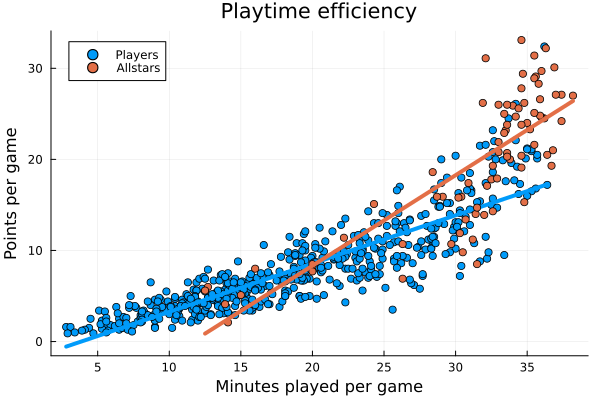

In [154]:
# To make a ColorGradient for Heatmaps: color_palette = cgrad(Sample color scheme = :roma, scale = :log))
@df nbadf scatter(:MP, :PPG, group = :ALLSTAR, 
smooth = true, linewidth = 4,
title = "Playtime efficiency",
xlabel = "Minutes played per game",
ylabel = "Points per game",
label = ["Players" "Allstars"],
color_palette = palette(:auto))

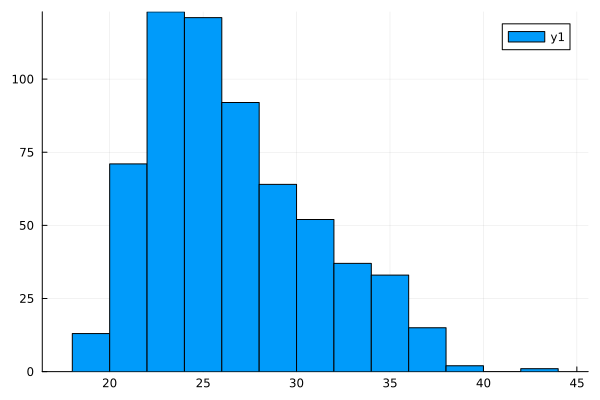

In [145]:
histogram(nbadf.Age)

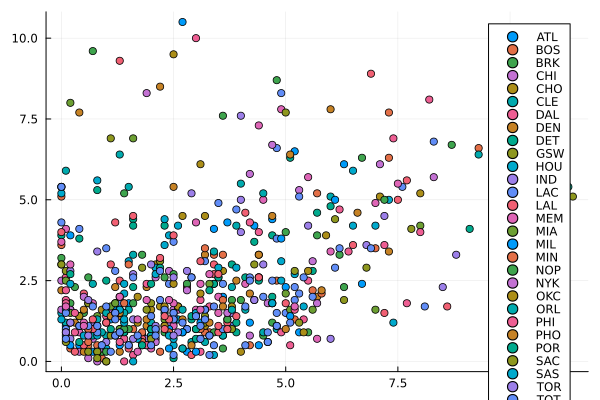

In [146]:
@df nbadf scatter(:ThreePA, :TwoP, group = :Tm)

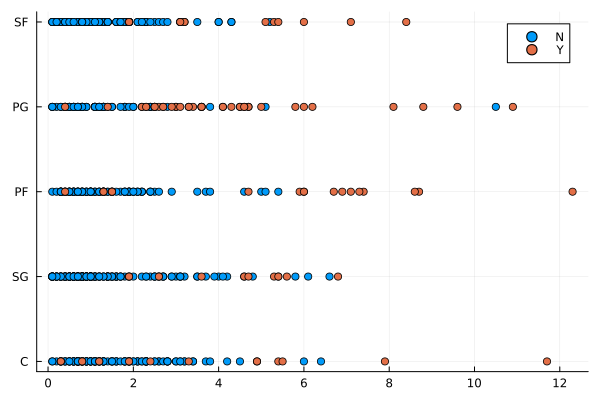

In [147]:
scatter(nbadf.FTA, nbadf.Pos,group = nbadf.ALLSTAR)
